# Population Studies at 75 Years

## A scientometric review in honour of the journal's 75th birthday

Last updated: 2021-02-20

By Melinda C. Mills and Charles Rahal

### 1. Preamble

Lets first load in some functions we've created for analysis:

In [1]:
import os
import nltk
import pandas as pd
from popstudies_preprocessor import build_datasets, load_curated, make_stopwords
from popstudies_analysis import (make_word_vis, make_author_table,
                                 make_affil_plot, describe_lengths,
                                 summarize_scrape_and_curate,
                                 gender_over_time, gender_over_time_oneplot,
                                 headline_topics, uncited_ratios,
                                 make_mwc, make_mf_topics,
                                 plot_G, plot_G0_and_G1,
                                 plot_all_G, title_analysis, 
                                 make_network, authorship_per_paper,
                                 authorship_country, network_summary,
                                 simple_continental_analysis, split_continental_analysis,
                                 keyword_tabulation,
                                 open_access_analysis,
                                 describe_norms, visualise_mallet,
                                 uncited_papers)
from popstudies_lda import make_lda_model, make_mallet_model
import matplotlib
matplotlib.font_manager._rebuild()
%load_ext autoreload
%autoreload 2

And then define a couple of key I\O paths and load in some of key datasets\representations.

In [2]:
stop = make_stopwords()
d_path = os.path.abspath(os.path.join('..', 'data'))
figure_path = os.path.abspath(os.path.join('..', 'article',
                                           'figures'))
main_df, ref_df, auth_df = build_datasets(d_path)
G, Gcc, authors_df, author_papers = make_network(auth_df)
#make_lda_model(main_df, d_path, stop)

There are 267 names we dont know about before calling genderize...
72 genderize calls remaining...!
After calling the genderize API, there are still 267 names which we dont know about!...


### 2. Basic summary statistics

Lets look at some basic descriptives of our cache of papers and authors:

In [3]:
summarize_scrape_and_curate(main_df, auth_df, ref_df, G, Gcc, d_path)

Total number of papers in our main database: 1901
Total number of papers in our author database: 1900
Papers with no abstract: 185
In our main dataframe there are 1858 Articles.
In our main dataframe there are 5 Editorials.
In our main dataframe there are 19 Erratums.
In our main dataframe there are 2 Letters.
In our main dataframe there are 6 Notes.
In our main dataframe there are 11 Reviews.
Total number of authorships: 3267
Total number of unique authors: 2027
Average number of references per paper: 24.76801683324566
Average number of authors per paper: 1.719
The most number of refrences in one paper: 311 (DOI: 10.1080/00324720600646410)
Date of first article: 1947-01-01
Date of most recent article: 2020-09-01
Average paper length (pages): 15.44390243902439
Number of OpenAccess articles: 52
The average number of citations is: 22.354550236717518
The maximum number of citations is: 732(10.1080/713779060)
Number of papers with no citations: 189
Percent of inter-affiliation collaboratio

### 3. Visualisations and more indepth analysis

#### 3.1 Describe the lengths of the articles over time:

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


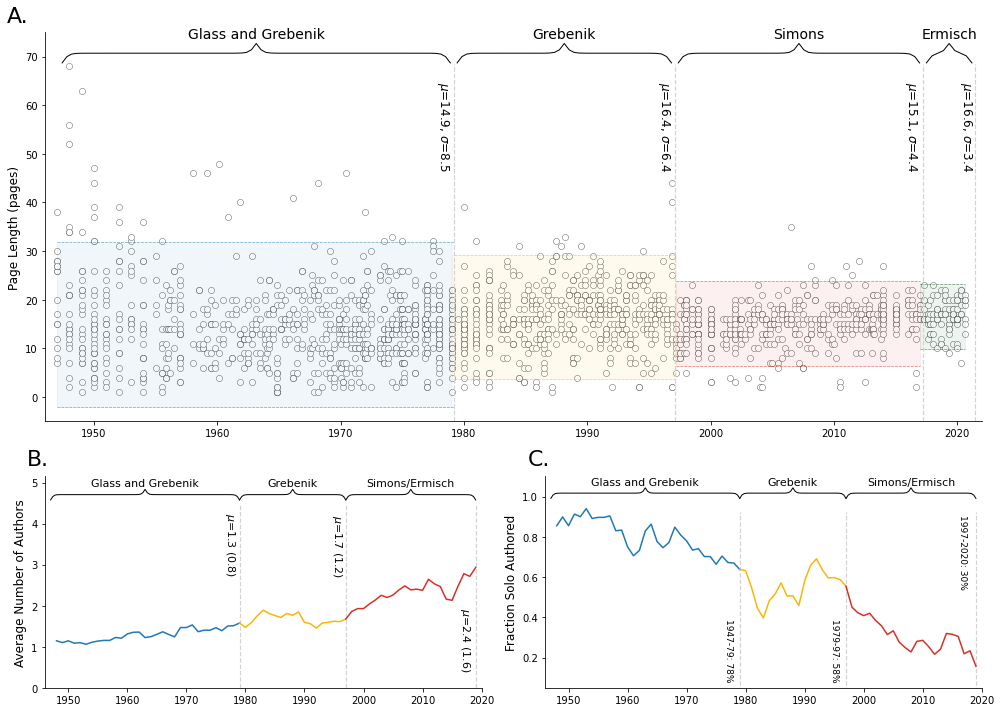

In [4]:
import os
import nltk
import pandas as pd
from popstudies_preprocessor import build_datasets, load_curated, make_stopwords
from popstudies_analysis import (make_word_vis, make_author_table,
                                 make_affil_plot, describe_lengths,
                                 summarize_scrape_and_curate,
                                 gender_over_time, gender_over_time_oneplot,
                                 headline_topics, uncited_ratios,
                                 make_mwc, make_mf_topics,
                                 plot_G, plot_G0_and_G1,
                                 plot_all_G, title_analysis, 
                                 make_network, authorship_per_paper,
                                 authorship_country, network_summary,
                                 simple_continental_analysis, split_continental_analysis,
                                 keyword_tabulation,
                                 open_access_analysis,
                                 describe_norms, visualise_mallet,
                                 uncited_papers)
from popstudies_lda import make_lda_model, make_mallet_model
import matplotlib
matplotlib.font_manager._rebuild()
%load_ext autoreload
%autoreload 2

describe_norms(main_df, auth_df)

In [5]:
title_analysis(main_df)

Mean length of titles: 75.33140452393476 characters
Max length of titles: 216 characters
Min length of titles: 5 characters
The shortest title is: Notes
The longest title is: A note on: The joint effect of maternal malnutrition and cold weather on neonatal mortality in nineteenthcentury venice: An assessment of the hypothermia hypothesis, population studies 63(3): 233-251 by renzo derosas
Mean length of titles, first half of period: 65.24947368421053 characters
Mean length of titles, second half of period: 85.40273396424816 characters


#### 3.2 Word Frequencies:

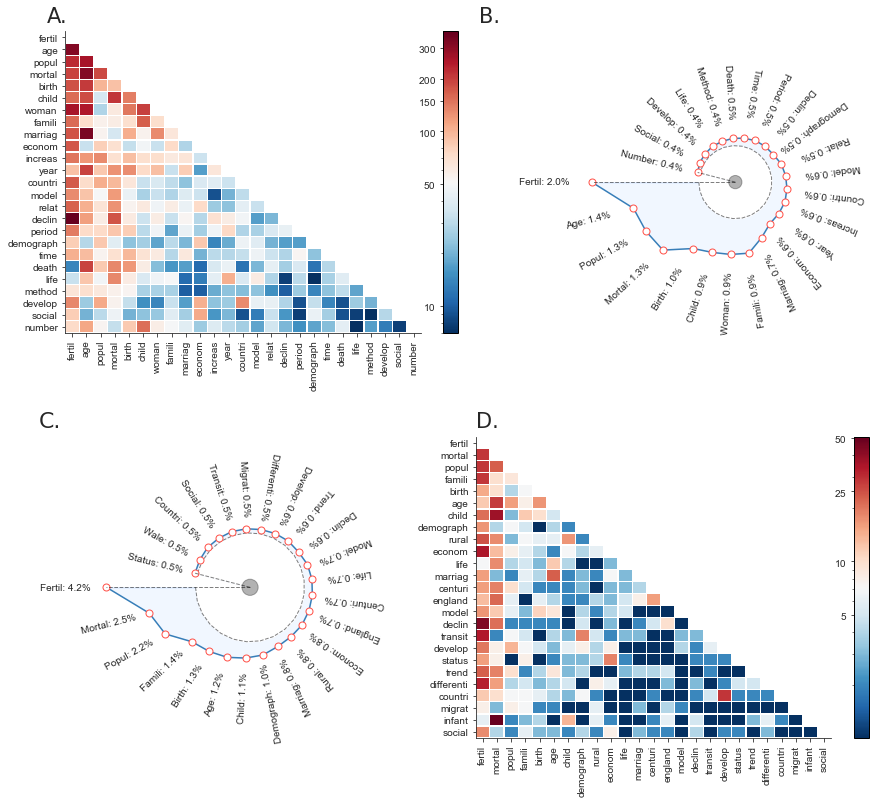

In [6]:
make_word_vis(main_df, figure_path, d_path)

And now something for keywords:

In [7]:
keyword_tabulation(main_df)

We have keywords for 398 papers
We have a total of 2591 keywords

The top 10 keywords are:
keyword
fertility                83
mortality                46
education                25
china                    23
marriage                 23
historical demography    22
migration                19
infant mortality         18
life expectancy          17
ageing                   16
Name: keyword, dtype: int64


#### 3.3 Authorship

In [8]:
authorship_per_paper(auth_df)

Average number of authors per paper in the 1940s: 1.145
Average number of authors per paper in the 1950s: 1.139
Average number of authors per paper in the 1960s: 1.28
Average number of authors per paper in the 1970s: 1.48
Average number of authors per paper in the 1980s: 1.724
Average number of authors per paper in the 1990s: 1.648
Average number of authors per paper in the 2000s: 2.213
Average number of authors per paper in the 2010s: 2.468
The most number of authors on one paper: 18 (DOI: 10.1080/00324728.2019.1595099)
The number of solo authored papers: 1106
The number of papers with 2 authors is : 454
The number of papers with 3 authors is : 211
The number of papers with more than 3 authors is : 129
Percent of solo authored papers in the 1940s: 0.855
Percent of solo authored papers in the 1950s: 0.887
Percent of solo authored papers in the 1960s: 0.8
Percent of solo authored papers in the 1970s: 0.699
Percent of solo authored papers in the 1980s: 0.509
Percent of solo authored pape

Who are the most prolific\influential authors in our dataset?

In [9]:
make_author_table(auth_df, main_df, d_path, 'Papers')

                     Papers  Cites  H-Index  HM-Index First  Last
fullname                                                         
John C. Caldwell         20   1351       13        12  1963  2004
Robert G. Potter         20    294        9         6  1956  1986
John E. Knodel           15    620       11        10  1967  2000
D. V. Glass              15     78        5         5  1950  1971
Samuel H. Preston        14   1204       11        11  1974  2016
Ronald F. Freedman       13    258       10         6  1954  1990
Michael J. Murphy        12    383       11         9  1985  2016
John N. Hobcraft         11    644        8         7  1982  2006
Alberto Palloni          11    204        7         6  1975  2009
John P.M. Bongaarts      11    424        9         9  1976  2019


In [10]:
make_author_table(auth_df, main_df, d_path, 'Cites')

                   Papers  Cites  H-Index  HM-Index First  Last
fullname                                                       
John C. Caldwell       20   1351       13        12  1963  2004
Samuel H. Preston      14   1204       11        11  1974  2016
Larry L. Bumpass        5    801        4         4  1982  2000
Hsien Hen Lu            1    732        1         1  2000  2000
John G.F. Cleland       7    686        6         6  1987  2003
Chris Wilson            6    677        6         6  1981  1999
Thomas McKeown          6    649        5         5  1955  1978
John N. Hobcraft       11    644        8         7  1982  2006
John E. Knodel         15    620       11        10  1967  2000
R. G. Record            3    504        3         3  1962  1975


In [11]:
make_author_table(auth_df, main_df, d_path, 'H-Index')

                     Papers  Cites  H-Index  HM-Index First  Last
fullname                                                         
John C. Caldwell         20   1351       13        12  1963  2004
John E. Knodel           15    620       11        10  1967  2000
Samuel H. Preston        14   1204       11        11  1974  2016
Michael J. Murphy        12    383       11         9  1985  2016
Ronald F. Freedman       13    258       10         6  1954  1990
John P.M. Bongaarts      11    424        9         9  1976  2019
Robert G. Potter         20    294        9         6  1956  1986
James Trussell           10    405        9         7  1977  1996
John N. Hobcraft         11    644        8         7  1982  2006
Dov Friedlander           8    219        8         6  1966  2002


In [12]:
make_author_table(auth_df, main_df, d_path, 'HM-Index')

                     Papers  Cites  H-Index  HM-Index First  Last
fullname                                                         
John C. Caldwell         20   1351       13        12  1963  2004
Samuel H. Preston        14   1204       11        11  1974  2016
John E. Knodel           15    620       11        10  1967  2000
John P.M. Bongaarts      11    424        9         9  1976  2019
Michael J. Murphy        12    383       11         9  1985  2016
Mead T. Cain              7    250        7         7  1982  1991
Robert I. Woods           7    366        7         7  1983  2005
Gigi Santow               9    358        7         7  1979  1998
James Trussell           10    405        9         7  1977  1996
Henri Léridon             9    306        7         7  1969  2008


What do we know about the authors as a whole?

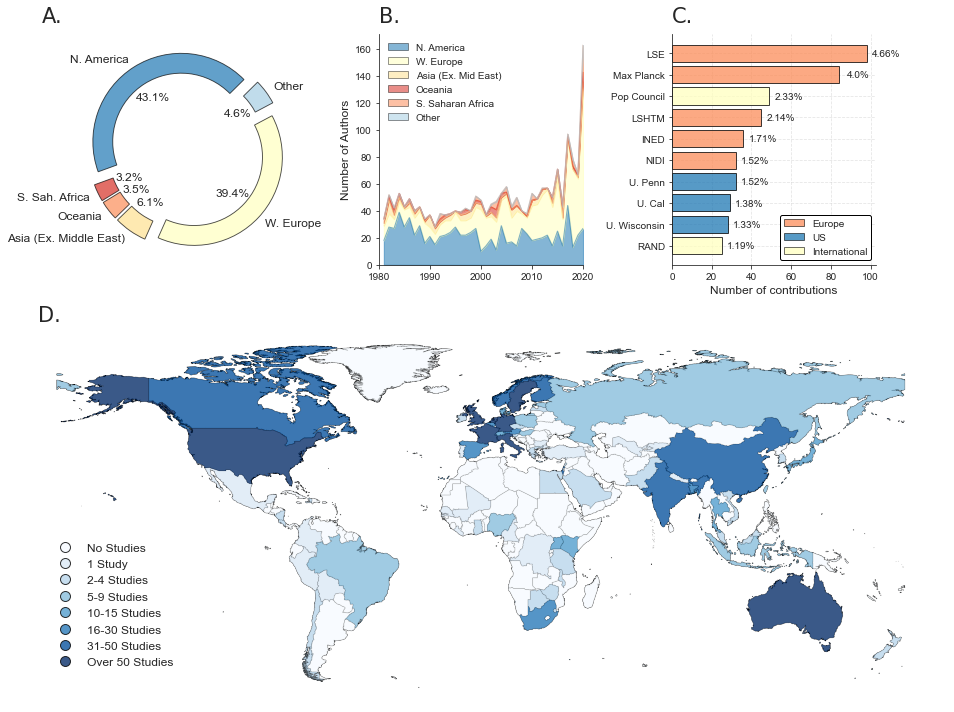

In [13]:
make_affil_plot(main_df, auth_df, d_path, figure_path)

In [14]:
authorship_country(auth_df, d_path)

Number of unique countries from which authors write from: 73

These are: United States (935), United Kingdom (343), Netherlands (115), Germany (86), Australia (76), Sweden (60), France (55), Italy (53), Canada (41), Finland (40), Israel (38), China (36), India (33), Norway (31), Austria (28), Spain (24), Belgium (22), Bangladesh (18), South Africa (17), Switzerland (15), Uganda (14), Denmark (13), Kenya (11), Thailand (11), Japan (10), Brazil (8), Estonia (8), Indonesia (7), Hungary (7), Nigeria (7), Poland (6), Singapore (6), Taiwan (5), Russian Federation (5), New Zealand (4), Zimbabwe (4), Czech Republic (4), Greece (4), Lebanon (3), Viet Nam (3), Malaysia (3), Tanzania (3), Chile (3), Swaziland (3), Slovenia (3), Ghana (3), Saudi Arabia (2), Botswana (2), Costa Rica (2), South Korea (2), Egypt (2), Latvia (2), Malawi (2), Pakistan (2), Haiti (2), Nicaragua (2), Ireland (2), Gambia (1), Cameroon (1), Uzbekistan (1), Bolivia (1), Mali (1), Bulgaria (1), Turkey (1), Colombia (1), Mexi

#### 3.4 Authorship gender

Lets look at authorship gender over time:

                  pc_guess_fem_10  pc_detect_fem_10
pc_guess_fem_10          1.000000          0.964411
pc_detect_fem_10         0.964411          1.000000
The max of Gender Detector is: 0.44623655913978494
The min of Gender Detector is: 0.1523809523809524
The max of Gender Guesser is: 0.4606741573033708
The min of Gender Guesser is: 0.18828451882845187
Percent of female authorships (full sample): 34.11%


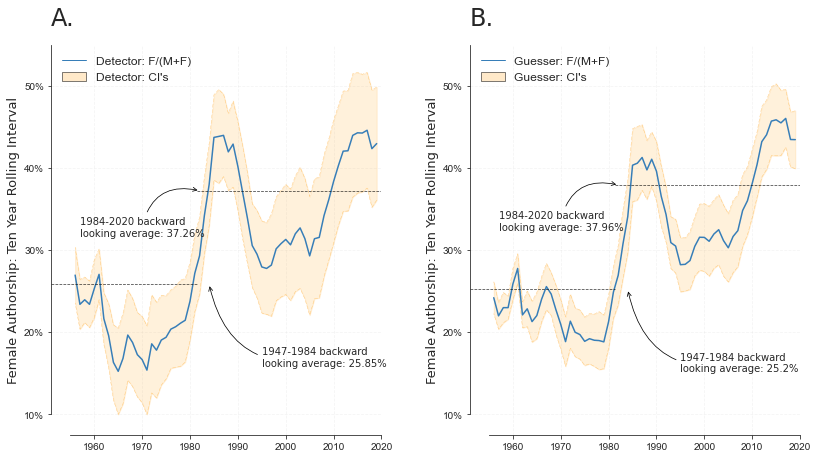

In [15]:
gender_over_time(auth_df[auth_df['forename']!='NAN'])

Percent of female authorships (full sample): 34.11%


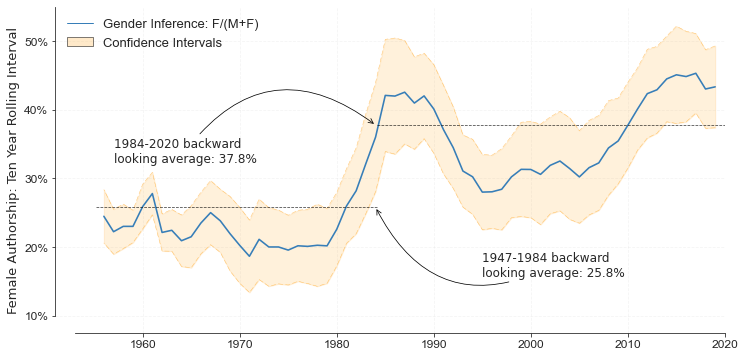

In [16]:
gender_over_time_oneplot(auth_df[auth_df['forename']!='NAN'])

In [17]:
auth_df['clean_gender'].unique()

array(['male', 'female', 'unknown', nan], dtype=object)

#### 3.5 Topics Studied

Lets now look at the topics studied, first over time:

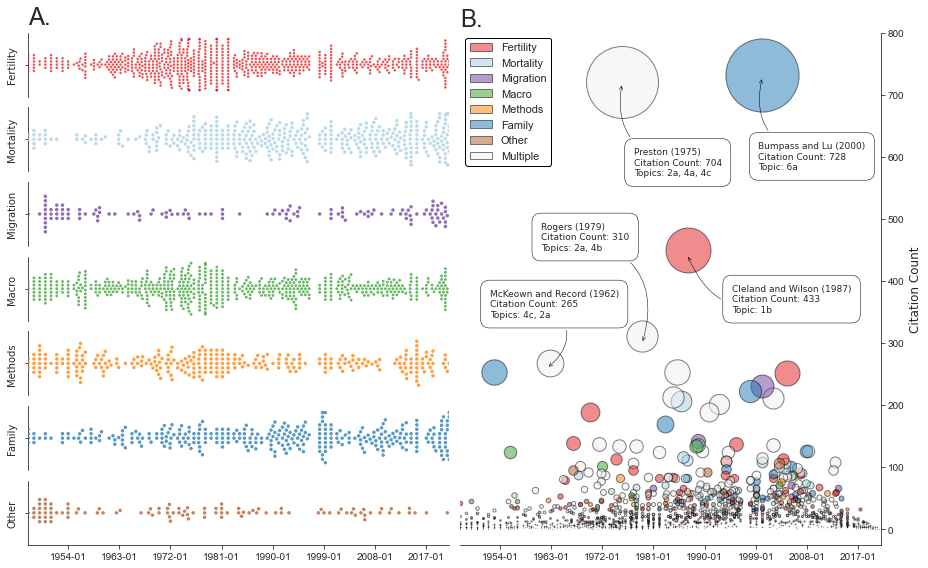

In [18]:
headline_topics(main_df)

and now decompose it into what apers focus on men, women or children:

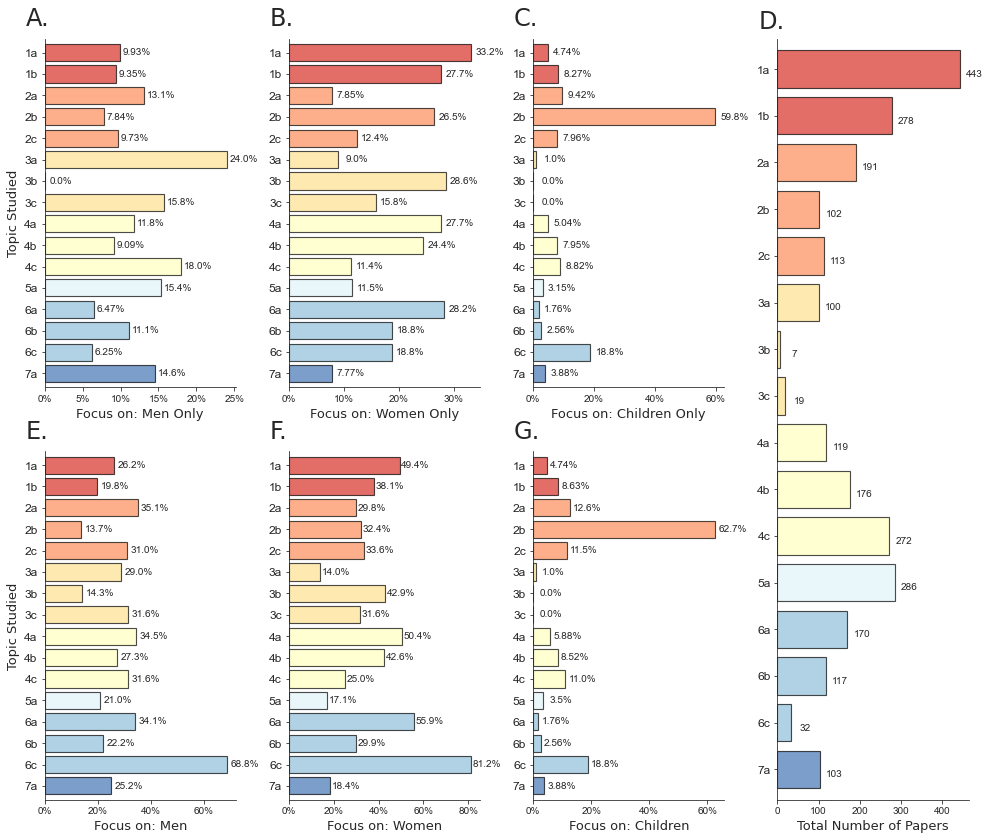

In [19]:
make_mwc(main_df, 'full')

In [20]:
make_mwc(main_df.sort_values(by='prismcoverdate', ascending=True)[0:int(len(main_df)/2)], 'firsthalf')

       All_Count  Women_Count  Children_Count  Men_Count
Topic                                                   
7a            65     6.153846        4.615385  12.307692
6c             3     0.000000        0.000000   0.000000
6b            49    22.448980        2.040816  16.326531
6a            63    26.984127        3.174603   7.936508
5a           164    11.585366        3.048780  17.073171
4c           182     9.890110        7.692308  17.582418
4b            75    26.666667        8.000000   8.000000
4a            54    31.481481        7.407407  18.518519
3c             8    25.000000        0.000000   0.000000
3b             4    25.000000        0.000000   0.000000
3a            48     4.166667        0.000000  27.083333
2c            18     5.555556       22.222222  11.111111
2b            32    21.875000       62.500000   9.375000
2a            73     6.849315       16.438356  13.698630
1b           151    29.139073       11.258278   5.960265
1a           246    29.674797  

In [21]:
make_mwc(main_df.sort_values(by='prismcoverdate', ascending=True)[int(len(main_df)/2):], 'secondhalf')

       All_Count  Women_Count  Children_Count  Men_Count
Topic                                                   
7a            38    10.526316        2.631579  18.421053
6c            29    20.689655       20.689655   6.896552
6b            68    16.176471        2.941176   7.352941
6a           107    28.971963        0.934579   5.607477
5a           122    11.475410        3.278689  13.114754
4c            90    14.444444       11.111111  18.888889
4b           101    22.772277        7.920792   9.900990
4a            65    24.615385        3.076923   6.153846
3c            11     9.090909        0.000000  27.272727
3b             3    33.333333        0.000000   0.000000
3a            52    13.461538        1.923077  21.153846
2c            95    13.684211        5.263158   9.473684
2b            70    28.571429       58.571429   7.142857
2a           118     8.474576        5.084746  12.711864
1b           127    25.984252        4.724409  13.385827
1a           197    37.563452  

What about authorship across topics?

In [22]:
make_mf_topics(auth_df[auth_df['forename']!='NAN'], main_df, d_path)

   Topic_M Subtopics_M Topic_F Subtopics_F Topic_Ratio Subtopics_Ratio
1a     539         305     263         187        2.05            1.63
1b                 234                  76                        3.08
2a     344         159     207          72        1.66            2.21
2b                  76                  49                        1.55
2c                 109                  86                        1.27
3a      97          77      60          49        1.62            1.57
3b                   6                   4                         1.5
3c                  14                   7                         2.0
4a     399          90     202          57        1.98            1.58
4b                 136                  88                        1.55
4c                 173                  57                        3.04
5a     219         219      63          63        3.48            3.48
6a     225         118     190          83        1.18            1.42
6b    

#### 3.6 Populations Studied

What nations are the being being studied coming from?

In [23]:
main_df.groupby(['Nation'])['Nation'].count().sort_values(ascending=False)[:10]

Nation
United States     108
China              79
England; Wales     61
India              60
United Kingdom     54
England            43
Sweden             35
Bangladesh         31
Australia          24
Finland            22
Name: Nation, dtype: int64

Lets break this down into continents with some manual merging

In [24]:
print('We have continent data for: ' + \
      str(round(len(main_df[main_df['Continent'].notnull()]) /
                len(main_df)*100, 2)) + '% of papers.')
print(main_df.groupby(['Continent'])['Continent'].count())

We have continent data for: 70.54% of papers.
Continent
Africa           164
Asia             358
Europe           468
Multiple         100
North America    158
Oceana            33
South America     60
Name: Continent, dtype: int64


And finally lets crosstab this with Topics, and normalize (divide by sum) for column sums:

In [25]:
simple_continental_analysis(main_df, figure_path)

           Europe    Africa North America      Asia South America  Multiple    Oceana
Topic 1  0.229805  0.343220      0.351464  0.334630      0.360825  0.221429  0.215686
Topic 2  0.174095  0.177966      0.096234  0.163424      0.144330  0.185714  0.176471
Topic 3  0.048747  0.038136      0.071130  0.044747      0.092784  0.114286  0.117647
Topic 4  0.292479  0.194915      0.255230  0.229572      0.226804  0.214286  0.196078
Topic 5  0.064067  0.072034      0.092050  0.056420      0.072165  0.114286  0.058824
Topic 6  0.161560  0.131356      0.108787  0.143969      0.082474  0.107143  0.196078
Topic 7  0.029248  0.042373      0.025105  0.027237      0.020619  0.042857  0.039216


In [26]:
split_continental_analysis(main_df, figure_path)

            Europe    Africa North America      Asia South America  Multiple    Oceana
Topic 1a  0.119777  0.228814      0.221757  0.221790      0.195876  0.085714  0.098039
Topic 1b  0.110028  0.114407      0.129707  0.112840      0.164948  0.135714  0.117647
Topic 2a  0.079387  0.046610      0.054393  0.054475      0.092784  0.128571  0.156863
Topic 2b  0.045961  0.025424      0.016736  0.052529      0.051546  0.035714  0.000000
Topic 2c  0.048747  0.105932      0.025105  0.056420      0.000000  0.021429  0.019608
Topic 3a  0.038997  0.016949      0.058577  0.029183      0.061856  0.114286  0.117647
Topic 3b  0.005571  0.004237      0.004184  0.001946      0.000000  0.000000  0.000000
Topic 3c  0.004178  0.016949      0.008368  0.013619      0.030928  0.000000  0.000000
Topic 4a  0.033426  0.042373      0.033473  0.071984      0.061856  0.078571  0.019608
Topic 4b  0.077994  0.110169      0.092050  0.064202      0.061856  0.028571  0.039216
Topic 4c  0.181058  0.042373      0.129707 

#### 3.7 Network Stuff

Lets look at the entire network, coloured by the number of nodes in the subcomponent (not included in the main paper, perhaps?):

There are a total of 510 isolates in the full network


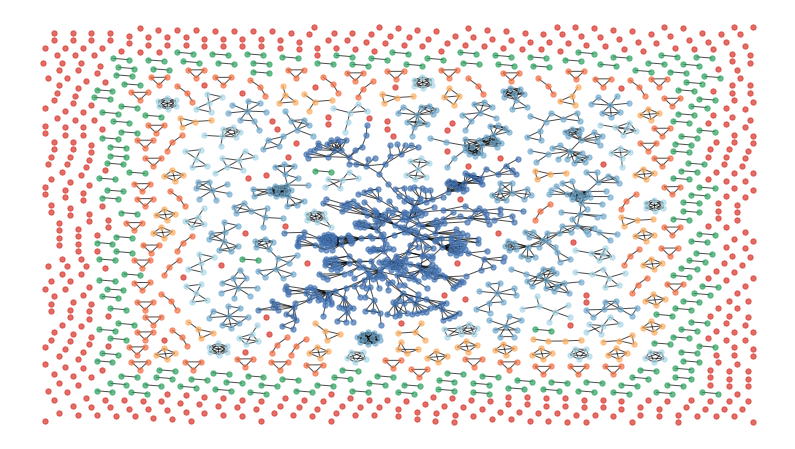

In [27]:
plot_G(G, figure_path)

Lets isolate the Giant and 'Second Giant' (?) components and visualise them:

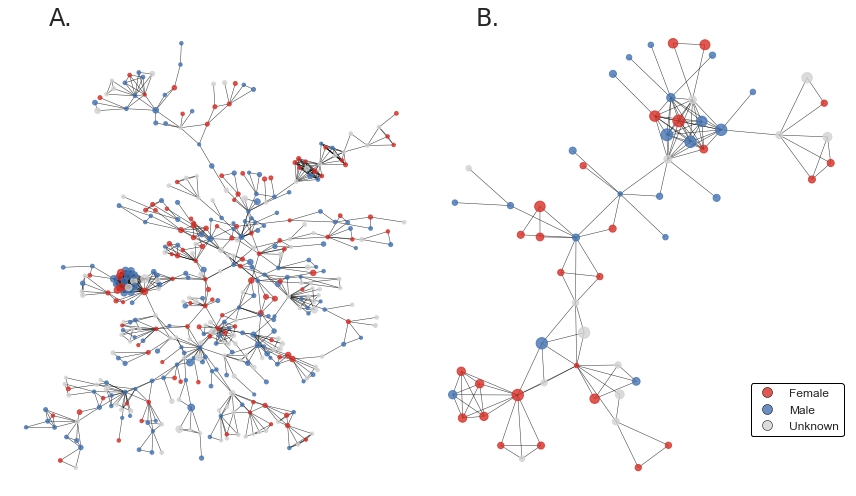

In [28]:
plot_G0_and_G1(G, authors_df, author_papers, figure_path)

Finally, print out some summary statistics from our network:

In [29]:
network_summary(G, Gcc)

Edges in entire network: 2317
Nodes in entire network: 2026
Density of entire network: 0.0011295138508037488
Edges in Giant Component: 926
Nodes in Giant Component: 433
Density of Giant Component: 0.009900778376528955


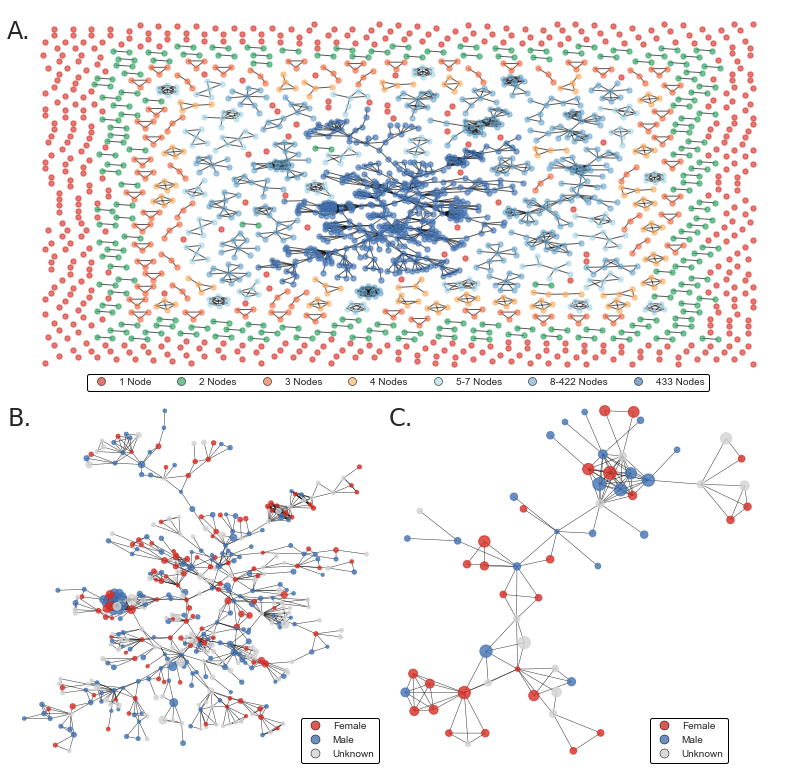

In [30]:
plot_all_G(G, authors_df, author_papers, figure_path)

In [31]:
authors_df.sort_values(by='degree', ascending=False)[0:10]

,authorid,indexed_name,degree,degree_cent,degree_bet
97,7.004308e+09,ZABA B.,28,0.013827,0.005188
98,2.295622e+10,MARSTON M.,23,0.011358,0.001063
1983,7.202992e+09,POTTER R.G.,19,0.009383,0.004498
429,7.402618e+09,HILL K.,19,0.009383,0.010071
93,2.653821e+10,RENIERS G.,19,0.009383,0.000628
1482,7.006608e+09,TRUSSELL J.,19,0.009383,0.021543
1774,7.202527e+09,FREEDMAN R.,18,0.008889,0.005925
100,5.535031e+10,KABUDULA C.,17,0.008395,0.000000
85,6.602861e+09,NALUGODA F.,17,0.008395,0.000000
84,5.631804e+10,NABUKALU D.,17,0.008395,0.000000


#### 3.8 LDA

In [32]:
mallet_topics_abs = make_mallet_model(main_df, d_path, stop, 'clean_abstract', 20)

[(0, '0.138*"marriage" + 0.070*"woman" + 0.058*"age" + 0.042*"cohort" + 0.029*"marital" + 0.027*"married" + 0.025*"proportion" + 0.023*"men" + 0.023*"divorce" + 0.020*"increase"'), (1, '0.109*"model" + 0.037*"method" + 0.022*"test" + 0.015*"base" + 0.014*"present" + 0.014*"propose" + 0.014*"apply" + 0.012*"approach" + 0.012*"series" + 0.011*"function"'), (2, '0.069*"century" + 0.030*"england" + 0.027*"nineteenth" + 0.022*"period" + 0.020*"wale" + 0.019*"early" + 0.016*"parish" + 0.016*"register" + 0.015*"eighteenth" + 0.014*"twentieth"'), (3, '0.340*"fertility" + 0.053*"decline" + 0.041*"urban" + 0.041*"rural" + 0.025*"transition" + 0.022*"differential" + 0.017*"marital" + 0.016*"area" + 0.015*"control" + 0.010*"parity"'), (4, '0.069*"migration" + 0.029*"behaviour" + 0.027*"migrant" + 0.023*"individual" + 0.018*"process" + 0.016*"decision" + 0.015*"cross" + 0.014*"white" + 0.012*"black" + 0.012*"social"'), (5, '0.055*"income" + 0.034*"distribution" + 0.034*"measure" + 0.034*"term" + 0.

In [33]:
mallet_topics_tit = make_mallet_model(main_df, d_path, stop, 'Title', 20)

[(0, '0.425*"population" + 0.082*"growth" + 0.057*"policy" + 0.031*"southern" + 0.022*"problem" + 0.019*"nigeria" + 0.017*"local" + 0.016*"general" + 0.015*"stable" + 0.015*"stationary"'), (1, '0.130*"model" + 0.081*"cohort" + 0.052*"base" + 0.046*"reproductive" + 0.042*"behaviour" + 0.037*"variation" + 0.033*"indian" + 0.032*"village" + 0.028*"process" + 0.025*"research"'), (2, '0.206*"child" + 0.147*"life" + 0.080*"health" + 0.056*"india" + 0.048*"education" + 0.042*"maternal" + 0.042*"estimation" + 0.039*"development" + 0.037*"expectancy" + 0.023*"service"'), (3, '0.163*"england" + 0.129*"decline" + 0.079*"wale" + 0.068*"africa" + 0.050*"south" + 0.036*"saharan" + 0.031*"abortion" + 0.029*"comment" + 0.022*"famine" + 0.020*"asia"'), (4, '0.238*"age" + 0.166*"marriage" + 0.077*"census" + 0.052*"distribution" + 0.036*"comparison" + 0.032*"childhood" + 0.024*"limitation" + 0.020*"longevity" + 0.016*"characteristic" + 0.013*"hong"'), (5, '0.154*"economic" + 0.136*"century" + 0.102*"stat

In [34]:
mallet_topics_abs.to_csv(os.path.join(os.getcwd(), '..', 'mallet_topics_abs.csv'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


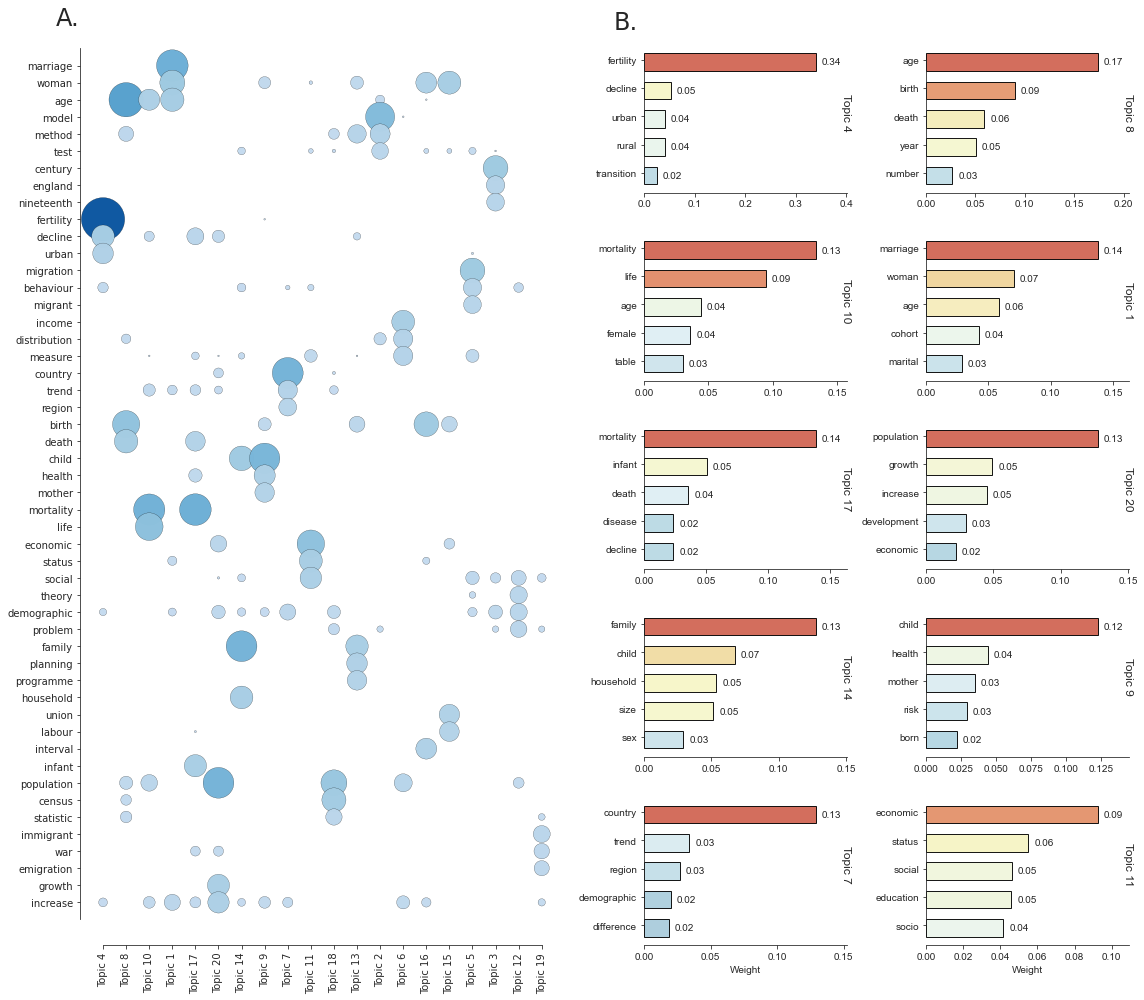

In [35]:
mallet_topics_abs = pd.read_csv('mallet_topics_abs.csv', index_col=0)
visualise_mallet(mallet_topics_abs)
%load_ext autoreload
%autoreload 2

     number_articles number_oa percent_OA
1947              16         0   0.000000
1948              22         0   0.000000
1949              24         0   0.000000
1950              33         0   0.000000
1951              19         0   0.000000
...              ...       ...        ...
2016              22         4  18.181818
2017              27         9  33.333333
2018              24         8  33.333333
2019              26         8  30.769231
2020              39        18  46.153846

[74 rows x 3 columns]


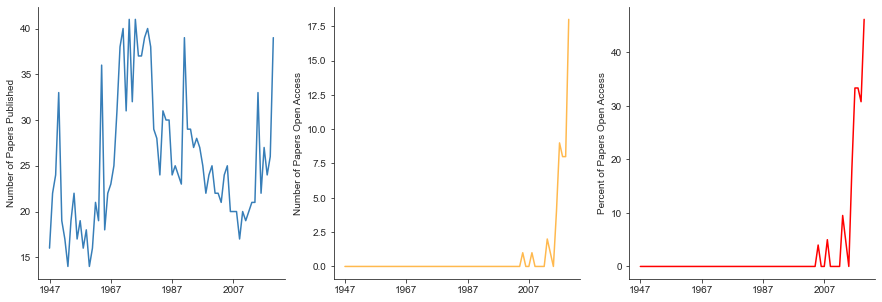

In [36]:
open_access_analysis(main_df, figure_path)

127


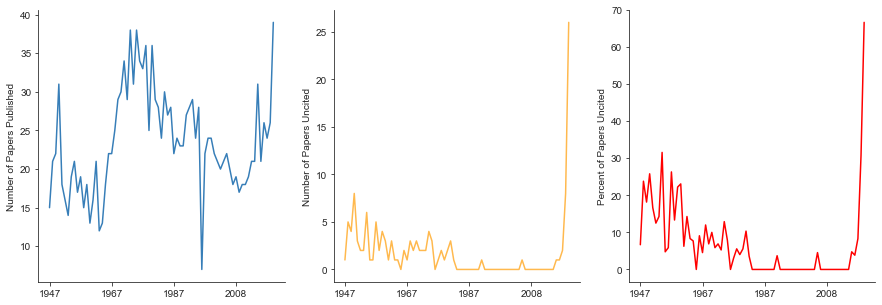

In [37]:
pd.set_option('mode.chained_assignment', None)
main_df_noabs = main_df[main_df['abstract'].str.len()>5]
main_df_noabs['year'] = main_df_noabs.copy(deep=True).Date.str.extract(r'([0-9][0-9][0-9][0-9])',
                                                 expand=True)
main_df_noabs
uncited_count = uncited_papers(main_df_noabs, figure_path)

In [38]:
topic_list = ['1a', '1b', '2a', '2b', '2c', '3a', '3b', '3c',
              '4a', '4b', '4c', '5a', '6a', '6b', '6c', '7a']
uncited_ratios(main_df, topic_list)

   number_papers uncited uncited_ratio
2b           100       2      0.020000
6a           165       5      0.030303
6c            31       1      0.032258
4a           114       5      0.043860
4c           260      12      0.046154
2a           181      10      0.055249
3c            18       1      0.055556
1a           414      29      0.070048
4b           164      12      0.073171
6b           108       9      0.083333
1b           256      22      0.085938
5a           260      26      0.100000
2c           102      11      0.107843
3a            90      10      0.111111
3b             6       1      0.166667
7a            84      19      0.226190


In [39]:
uncited_ratios(main_df_noabs, topic_list)

   number_papers uncited uncited_ratio
2b           100       2      0.020000
6a           165       5      0.030303
6c            31       1      0.032258
4a           114       5      0.043860
4c           260      12      0.046154
2a           181      10      0.055249
3c            18       1      0.055556
1a           413      29      0.070218
4b           164      12      0.073171
6b           108       9      0.083333
1b           256      22      0.085938
3a            90       9      0.100000
5a           260      26      0.100000
2c           102      11      0.107843
3b             6       1      0.166667
7a            84      18      0.214286


In [40]:
topic_list = range(1,8)
uncited_ratios(main_df, topic_list)

  number_papers uncited uncited_ratio
6           290      13      0.044828
4           520      29      0.055769
2           374      23      0.061497
1           663      51      0.076923
5           260      26      0.100000
3           113      12      0.106195
7            84      19      0.226190


In [41]:
uncited_ratios(main_df_noabs, topic_list)

  number_papers uncited uncited_ratio
6           290      13      0.044828
4           520      29      0.055769
2           374      23      0.061497
1           662      51      0.077039
3           113      11      0.097345
5           260      26      0.100000
7            84      18      0.214286
